# System Identification using the Ho-Kalman method

### Imports

Note, for MIMO systems, package slycot must be installed a swell.

In [1]:
import numpy as np
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
import control_matrices as cm
import control as ct 
from matrepr import mdisplay
from IPython.display import display, Math, Latex

### System
Here, the true state space system $\Sigma$ is created. In reality, we wouldn't know this system or the matrices
defining it. The system is defined as:
$\begin{align}
    x[k+1] &= Ax[k] + Bu \\
    y[k] &= Cx[k] + Du
\end{align}$
where $A \in \mathbb{R}^{nxn}, B \in \mathbb{R}^{nxp}, C \in \mathbb{R}^{qxn}, D \in \mathbb{R}^{qxp}$,\
$x \in \mathbb{R}^{nx1}, u \in \mathbb{R}^{px1}$ and $y \in \mathbb{R}^{qx1}$.\
$n$ is the system order, $p$ the number of inputs and $q$ the number of outputs.

In [2]:
# %% System
A = np.array([[0,1,0,0],
              [-0.5,-0.4,0,-0.5],
              [0,0,0.2,-1],
              [0,0,0,-0.8]]
              )

B = np.array(
    [[0,0],
     [1,0],
     [0,0],
     [0,1]]
)
C = np.array(
    [[1,0,0,0],
     [0,0,2,1]]
    )
D = np.array([[0.0, 0.0], [0.0, 0.0]])


# This line will raise an error if state space is not
# appropriately dimensioned.
cm.check_state_space_dimensions(A, B, C, D)

mdisplay(A, title='A')
mdisplay(B, title='B')
mdisplay(C, title='C')
mdisplay(D, title='D')

# We will need the dimensions of the system later.
n = A.shape[0]
p = B.shape[1]
q = C.shape[0]

# Some sanity checks on the system.
poles = np.linalg.eigvals(A)

mdisplay(np.real_if_close(poles),title="Poles")
if np.all(np.abs(poles) < 1):
    display("A is stable.")
else:
    display("A is not stable.")


,0,1,2,3
0,0,1,0,0
1,-0.5,-0.4,0,-0.5
2,0,0,0.2,-1
3,0,0,0,-0.8


,0,1
0,0,0
1,1,0
2,0,0
3,0,1


,0,1,2,3
0,1,0,0,0
1,0,0,2,1


,0,1
0,0,0
1,0,0


0,1,2,3
-0.2+0.6782i,-0.2--0.6782i,0.2+0i,-0.8+0i


'A is stable.'

### Checking controllability and observability

In [3]:
ctr = cm.make_controllability_matrix(A, B)
ctr_rank = np.linalg.matrix_rank(ctr)
ctr_str = fr"=n={n}\rightarrow$ Controllable" if ctr_rank==n else fr"<n={n}\rightarrow$ Not Controllable"
mdisplay(ctr, title="'Controllability Matrix")
display(Latex(fr"$rank(\mathcal{{C}})={ctr_rank}" + ctr_str))

obs = cm.make_observability_matrix(A, C)
obs_rank = np.linalg.matrix_rank(obs)
obs_str = fr"=n={n}\rightarrow$ Observable" if obs_rank==n else fr"<n={n}\rightarrow$ Not Observable"
mdisplay(obs, title="'Observability Matrix")
display(Latex(fr"$rank(\mathcal{{O}})={obs_rank}" + obs_str))

,0,1,2,3,4,5,6,7
0,0,0,1,0,-0.4,-0.5,-0.34,0.6
1,1,0,-0.4,-0.5,-0.34,0.6,0.336,-0.31
2,0,0,0,-1,0,0.6,0,-0.52
3,0,1,0,-0.8,0,0.64,0,-0.512


<IPython.core.display.Latex object>

,0,1,2,3
0,1,0,0,0
1,0,0,2,1
2,0,1,0,0
3,0,0,0.4,-2.8
4,-0.5,-0.4,0,-0.5
5,0,0,0.08,1.84
6,0.2,-0.34,0,0.6
7,0,0,0.016,-1.552


<IPython.core.display.Latex object>

### Input-output data
Here, we're gathering $N$ input-output data samples from which to extract the markov parameters
$\mathcal{Y} = \left[ \begin{array}{cccc} D & CB & CAB & \cdots & CA^{N-2}B \end{array} \right]$ using $Y = \mathcal{Y}U$ where

$
\begin{align}
Y &= \left[ \begin{array}{cccc} y[0] & y[1] & \cdots & y[N-1] \end{array} \right] \\
U &= \left[ \begin{array}{cccc}
    u[0] & u[1] & \cdots & u[N-1] \\
      0  & u[0] & \cdots & u[N-2] \\
      0  &  0   & \cdots & u[N-3] \\
    \vdots&\vdots&\vdots &\vdots   \\
      0  &  0   & \cdots & u[0]
    \end{array} \right]
\end{align}
$
and $Y \in \mathbb{R}^{qxN}, \mathcal{Y} \in \mathbb{R}^{qxpN}$ and $U \in \mathbb{R}^{pNxN}$. \
The estimated markov parameters $\hat{\mathcal{Y}}$ are then found using least squares using $\hat{\mathcal{Y}} = YU^{\dagger}$
where $U^{\dagger}$ denotes the pseudo-inverse of $U$. \
For this, $U$ needs to be well conditioned such that the pseudo-inverse is well defined.

Also, note that these estimated markov parameters are not likely to be the same as the true
markov parameters. If the input-output data is good however, they should be related to a
similar system $\hat{\Sigma}$ through the relations:
$
\begin{equation}
  \hat{A} = T^{-1}AT, \hat{B} = T^{-1}B, \hat{C} = CT, \hat{D} = D
\end{equation}
$
where T is an invertible similarity matrix. $\hat{\Sigma}$ will have the same input-output relation and poles as the original system $\Sigma$.

$U, Y, \hat{\mathcal{Y}}$ and $\mathcal{Y}$ are shown after the cell, as well as the input-output response.

,0,1,2,3,4,5,6,,93,94,95,96,97,98,99
0,-45.68,-45.68,-45.68,-45.68,-45.68,-45.68,-45.68,⋯,-45.68,-45.68,-45.68,-45.68,-45.68,-45.68,-45.68
1,-35.98,-35.98,-35.98,-35.98,-35.98,-35.98,-35.98,⋯,-35.98,-35.98,-35.98,-35.98,-35.98,-35.98,-35.98
2,0,-31.8,-31.8,-31.8,-31.8,-31.8,-31.8,⋯,-31.8,-31.8,-31.8,-31.8,-31.8,-31.8,-31.8
3,0,30.16,30.16,30.16,30.16,30.16,30.16,⋯,30.16,30.16,30.16,30.16,30.16,30.16,30.16
4,0,0,22.54,22.54,22.54,22.54,22.54,⋯,22.54,22.54,22.54,22.54,22.54,22.54,22.54
,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮
195,0,0,0,0,0,0,0,⋯,0,0,0,0,-6.916,-6.916,-6.916
196,0,0,0,0,0,0,0,⋯,0,0,0,0,0,-48.93,-48.93
197,0,0,0,0,0,0,0,⋯,0,0,0,0,0,-36.13,-36.13
198,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,28.92


,0,1,2,3,4,5,6,,93,94,95,96,97,98,99
0,0,0,-45.68,4.466,14.12,57.93,-60.78,⋯,-24.8,-78.47,79.65,2.061,1.415,-81.13,79.49
1,0,-35.98,130.9,-150.3,77.25,-35.51,94.14,⋯,-195.9,107.6,-125,191.5,-142.5,54.32,-76.31


,0,1,2,3,4,5,6,,193,194,195,196,197,198,199
0,0,0,0,0,-2.026,-0.03543,0.7366,⋯,-0.7256,-0.01884,0.003975,1.092,0.8062,1.477,-2.454
1,0,0,0.5956,-0.565,7.401,0.1294,-4.13,⋯,2.959,-9.754,2.058,-2.604,-1.923,-1.201,1.996


,0,1,2,3,4,5,6,,193,194,195,196,197,198,199
0,0,0,0,0,1,0,-0.4,⋯,3.791e-10,3.554e-15,-3.032e-10,-3.321e-15,2.426e-10,-4.488e-16,-1.941e-10
1,0,0,0,1,0,-2.8,0,⋯,-1.865e-09,0,1.492e-09,0,-1.194e-09,0,9.549e-10


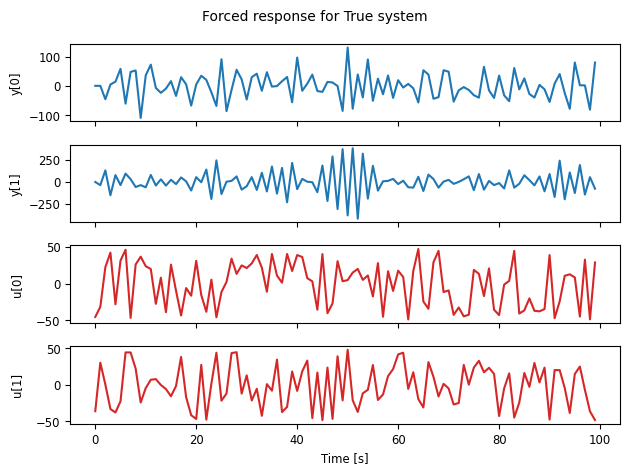

In [16]:
### Parameters for input data and system simulation.
# Whether to calculate rank and conditioning number for U.
# Might take a long time for large N.
calc_rank = True

# Nr of input samples.
N = 100
# Input signal(s).
# Random noise usually makes for a well conditioned matrix.
u = np.random.uniform(-50, 50, size=(p,N))

true_sys = ct.ss(A,B,C,D,dt=True, name='True system')
resp = ct.forced_response(true_sys,U=u)
resp.plot()
plt.plot()

# Making U
u_interleaved = cm.interleave_vectors(*u)
U = cm.make_input_Toeplitz_matrix(u_interleaved, p)
rank_str = (f', rank: {np.linalg.matrix_rank(U)}, Conditioning Nr: {np.linalg.cond(U)}'
            if calc_rank else '.')
mdisplay(U, title=f'U, shape: {U.shape}' + rank_str)

Y = resp.y
mdisplay(Y, title=f'Y, shape: {Y.shape}')

# Markov Parameters
MP = Y@np.linalg.pinv(U)
mdisplay(np.where(np.isclose(0,MP),0,MP), title=f'Estimated Markov Parameters, shape: {MP.shape}, (q,p,N)={q,p,N}')

MP_true = cm.compute_markov_parameters(A,B,C,D,N)
mdisplay(MP_true, title=f'True Markov Parameters')

### Hankel Matrix
Constructing the markov parameter Hankel matrix and getting the extended Controllability and Observability Matrices.

In [17]:
H = cm.make_Hankel_matrix(MP[:,p:-p], int((N-p)/2), p, q)
H_shifted = cm.make_Hankel_matrix(MP[:,2*p:], int((N-q)/2), p, q)
mdisplay(H, title='Markov Parameter Hankel Matrix')

# Taking the SVD of H
U_MP, s_MP ,Vh_MP = np.linalg.svd(H, full_matrices=False)
# s_MP[np.isclose(np.zeros(s_MP.shape),s_MP)] = 0
# S_MP = np.diag(s_MP)

# # Extracting the observability matrix O and controllability Matrix Cr from the SVD of H.
# O = U_MP@sqrtm(S_MP, 1/2)
# O = O[:,~np.all(O == 0, axis=0)]
# Cr = sqrtm(S_MP, 1/2)@Vh_MP
# Cr = Cr[~np.all(Cr==0, axis=1),:]

s_MP
#mdisplay(O, title='Extended Observability Matrix')
#mdisplay(Cr, title='Extended Controllability Matrix')

,0,1,2,3,4,5,6,,93,94,95,96,97,98,99
0,7.69e-14,-7.136e-14,-2.026,-0.03543,0.7366,-0.5728,-0.123,⋯,0.0309,-0.1486,-0.1885,-0.5946,3.916,0.4465,4.472
1,0.5956,-0.565,7.401,0.1294,-4.13,3.211,-2.898,⋯,-8.061,-7.405,-9.389,4.728,-31.14,-1.547,-15.49
2,-2.026,-0.03543,0.7366,-0.5728,-0.123,-0.1637,0.9212,⋯,-0.1885,-0.5946,3.916,0.4465,4.472,-4.703,6.556
3,7.401,0.1294,-4.13,3.211,-2.898,-3.856,-2.371,⋯,-9.389,4.728,-31.14,-1.547,-15.49,17.1,-23.83
4,0.7366,-0.5728,-0.123,-0.1637,0.9212,-0.6563,-1.339,⋯,3.916,0.4465,4.472,-4.703,6.556,1.327,-2.44
,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮
93,-4.729,-8.061,-7.405,-9.389,4.728,-31.14,-1.547,⋯,13.98,2.361,-7.128,-6.749,-11.83,-5.362,2.959
94,-0.1486,-0.1885,-0.5946,3.916,0.4465,4.472,-4.703,⋯,1.26,4.588,8.044,1.315,-0.7256,-0.01884,0.003975
95,-7.405,-9.389,4.728,-31.14,-1.547,-15.49,17.1,⋯,-7.128,-6.749,-11.83,-5.362,2.959,-9.754,2.058
96,-0.5946,3.916,0.4465,4.472,-4.703,6.556,1.327,⋯,8.044,1.315,-0.7256,-0.01884,0.003975,1.092,0.8062


array([165.3361647 , 157.2605565 , 150.13365249, 148.86713256,
       140.03582853, 138.77667312, 137.6675747 , 135.09345749,
       133.57270048, 132.95022669, 121.75525582, 121.52013103,
       119.27953836, 118.88673928, 118.49866287, 118.07254524,
       117.25677168, 115.7510556 , 114.84402842, 112.37298329,
       109.55201382, 108.64188103, 106.90770956, 106.29220656,
       104.11797758, 103.87066452, 101.6046002 ,  97.9140088 ,
        97.4419692 ,  91.64553491,  90.39807036,  86.12241004,
        83.1900913 ,  81.38745962,  79.45753759,  75.4628981 ,
        72.89073701,  72.66015653,  71.2474319 ,  69.52324263,
        67.28217252,  66.72810749,  60.52492347,  58.8617219 ,
        56.48775602,  50.75440352,  48.70578113,  40.72991651,
        39.56972356,  32.74399306,  30.51068337,  28.85006746,
        26.74428122,  26.736119  ,  26.00446954,  25.22197231,
        24.79912205,  23.86519023,  23.24130111,  22.57345896,
        22.367136  ,  22.04647953,  21.52202802,  21.46

In [18]:
MP_true = cm.compute_markov_parameters(A,B,C,D,N)
H = cm.make_Hankel_matrix(MP_true[:,p:-p], int((N-p)/2), p, q)
svals = np.linalg.svdvals(H)
mdisplay(svals)
mdisplay(H)

0,1,2,3,4,5,6,,91,92,93,94,95,96,97
8.034,1.928,1.464,1.301,4.683e-16,4.461e-16,3.466e-16,⋯,6.647e-27,4.643e-27,1.836e-27,1.555e-27,8.665e-28,5.094e-28,1.324e-28


,0,1,2,3,4,5,6,,93,94,95,96,97,98,99
0,0,0,1,0,-0.4,-0.5,-0.34,⋯,-2.127e-05,-7.616e-08,1.707e-05,8.184e-08,-1.361e-05,5.344e-09,1.085e-05
1,0,1,0,-2.8,0,1.84,0,⋯,0.0001045,0,-8.363e-05,0,6.69e-05,0,-5.352e-05
2,1,0,-0.4,-0.5,-0.34,0.6,0.336,⋯,1.707e-05,8.184e-08,-1.361e-05,5.344e-09,1.085e-05,-4.306e-08,-8.683e-06
3,0,-2.8,0,1.84,0,-1.552,0,⋯,-8.363e-05,0,6.69e-05,0,-5.352e-05,0,4.282e-05
4,-0.4,-0.5,-0.34,0.6,0.336,-0.31,0.0356,⋯,-1.361e-05,5.344e-09,1.085e-05,-4.306e-08,-8.683e-06,1.455e-08,6.968e-06
,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮
93,0,0.0001045,0,-8.363e-05,0,6.69e-05,0,⋯,3.643e-09,0,-2.914e-09,0,2.331e-09,0,-1.865e-09
94,-7.616e-08,1.707e-05,8.184e-08,-1.361e-05,5.344e-09,1.085e-05,-4.306e-08,⋯,5.923e-10,-1.015e-14,-4.738e-10,3.798e-15,3.791e-10,3.554e-15,-3.032e-10
95,0,-8.363e-05,0,6.69e-05,0,-5.352e-05,0,⋯,-2.914e-09,0,2.331e-09,0,-1.865e-09,0,1.492e-09
96,8.184e-08,-1.361e-05,5.344e-09,1.085e-05,-4.306e-08,-8.683e-06,1.455e-08,⋯,-4.738e-10,3.798e-15,3.791e-10,3.554e-15,-3.032e-10,-3.321e-15,2.426e-10
